In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
%tensorflow_version 2.x
import tensorflow
import tensorflow as tf
tensorflow.__version__

'2.4.0'

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Fri Jan 15 23:18:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |    359MiB / 16280MiB |      2%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                            

In [3]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import csv

import numpy as np 
import pandas as pd

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [6]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications import VGG16
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Reshape, Activation, Dropout, Flatten, Dense, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [7]:
from PIL import Image
import cv2
import pickle
import mimetypes
import imutils
import glob
import torch

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sn

In [9]:
## packages related to image Augmeantation
import imgaug as ia
ia.seed(1)
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
# imageio library will be used for image input/output
import imageio
import re

In [11]:
# Output folder

BASE_OUTPUT='/content/drive/MyDrive/Capstone/Prasad/20210115_3_1/'

# Dataset folder
dataset_folder='/content/drive/MyDrive/Capstone/car_data/'

'''
# unzipping input data 
images_zip_path=dataset_folder+'car_data_tmp.zip'
from zipfile import ZipFile
with ZipFile(images_zip_path, 'r') as z:
  z.extractall()
'''  

"\n# unzipping input data \nimages_zip_path=dataset_folder+'car_data_tmp.zip'\nfrom zipfile import ZipFile\nwith ZipFile(images_zip_path, 'r') as z:\n  z.extractall()\n"

In [12]:
train_csv=dataset_folder+'anno_train.csv'
test_csv=dataset_folder+'anno_test.csv'
names_csv_path=dataset_folder+'names_updated.csv'


#test_data_folder='/content/drive/MyDrive/Capstone/car_data/test'
#train_data_foder='/content/drive/MyDrive/Capstone/car_data/train'

#croped_train_data=dataset_folder+'croped_car_data_tmp/train/'
#croped_test_data=dataset_folder+'croped_car_data_tmp/test/'

#For output storing

MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])


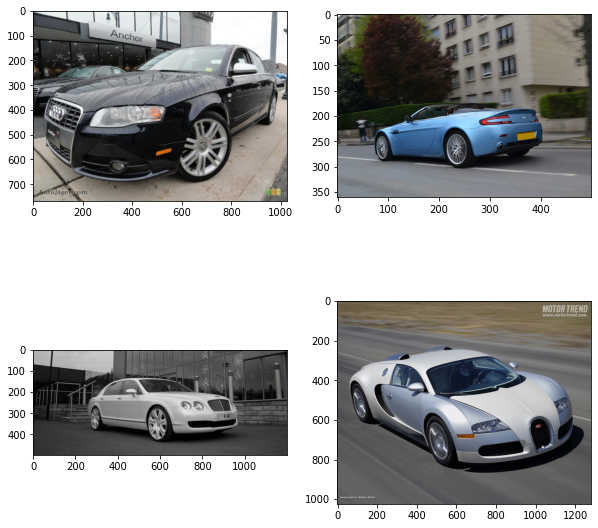

In [13]:

## Displaying images with different dimesions 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

img1 = plt.imread(dataset_folder +'train/Audi S4 Sedan 2007/00159.jpg')
img2 = plt.imread(dataset_folder+'train/Aston Martin V8 Vantage Convertible 2012/00065.jpg')
img3 = plt.imread(dataset_folder+'train/Bentley Continental Flying Spur Sedan 2007/00057.jpg')
img4 = plt.imread(dataset_folder+'train/Bugatti Veyron 16.4 Coupe 2009/01249.jpg')
ax = axes[0,0]
ax1 = axes[0,1]
ax2 = axes[1,0]
ax3 = axes[1,1]

ax.imshow(img1)
ax1.imshow(img2)
ax2.imshow(img3)
ax3.imshow(img4)


In [14]:
# loading class names into data frame

class_names=[]

with open(names_csv_path) as csvDataFile:
  csvReader=csv.reader(csvDataFile, delimiter =',')
  for row in csvReader:
    class_names.append(row[0])
    
class_names[:2]


['AM General Hummer SUV 2000', 'Acura RL Sedan 2012']

In [15]:
## Reading train annotations into data frame and storing into lists 

cars_annos_train=pd.read_csv(train_csv,header=None)
cars_annos_test=pd.read_csv(test_csv,header=None)
cars_annos_train.head(1)

,0,1,2,3,4,5
0,00001.jpg,39,116,569,375,14


In [16]:
cars_annos_test.head(1)

,0,1,2,3,4,5
0,00001.jpg,30,52,246,147,181


In [17]:
annotations=cars_annos_train.iloc[2]
file_names =annotations[0]
file_names

'00003.jpg'

In [18]:
#For Training data set 
file_names=[]
class_ids=[]
bboxes=[]
labels=[]

for i in range(len(cars_annos_train)):
  annotations=cars_annos_train.iloc[i]
  

  bboxs_x1=annotations[1]
  bboxs_x2=annotations[2]
  bboxs_x3=annotations[3]
  bboxs_x4=annotations[4]
  bboxes.append((bboxs_x1,bboxs_x2,bboxs_x3,bboxs_x4))

  class_id=annotations[5]
  labels.append('%04d' %(class_id,))

  file_names.append(annotations[0])

  class_ids.append(annotations[5])


In [19]:
## Compareing between file names, coordinates and their labels 
print(file_names[:5])
print(bboxes[:5])
print(class_ids[:5])
print(labels[:5])

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']
[(39, 116, 569, 375), (36, 116, 868, 587), (85, 109, 601, 381), (621, 393, 1484, 1096), (14, 36, 133, 99)]
[14, 3, 91, 134, 106]
['0014', '0003', '0091', '0134', '0106']


In [20]:
cars_annos_train.shape

(8144, 6)

In [21]:

# Use these presaved arrays to speed up the process#
trainData = np.load('/content/drive/MyDrive/Capstone/Prasad/MobileNet/14Jan_1/trainData.npy') # loads your saved array into variable a.
trainLabels = np.load('/content/drive/MyDrive/Capstone/Prasad/MobileNet/14Jan_1/trainLabels.npy')
trainBboxes = np.load('/content/drive/MyDrive/Capstone/Prasad/MobileNet/14Jan_1/trainBboxes.npy')
trainImagePaths = np.load('/content/drive/MyDrive/Capstone/Prasad/MobileNet/14Jan_1/trainImagePaths.npy')


In [22]:
#Run this to bring already generated augmentation images paths and corresponding bounding boxes dataframe
aug_bbs_xy = pd.read_csv('/content/drive/MyDrive/Capstone/Prasad/MobileNet/14Jan_1/aug_bbs_xy.csv')  

In [23]:
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

In [24]:
'''# Remove quotes in the front to generate augmentation images and corresponding bounding boxes dataframe

# This setup of augmentation parameters will pick two of four given augmenters and apply them in random order
augmentor = iaa.SomeOf(2, [    
    iaa.Affine(scale=(0.5, 1.5)),
    iaa.Affine(rotate=(-60, 60)),
    iaa.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}),
    iaa.Fliplr(1),
    iaa.Multiply((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
])

aug_images_path='/content/drive/MyDrive/Capstone/car_data/aug_images/'
#aug_images_path='/content/drive/MyDrive/TMP_MAIN_PROJECT_CAPSTONE/aug_images/'
image_prefix='aug1_'
aug_bbs_xy = pd.DataFrame(columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax','class'])


train_folder=glob.glob(dataset_folder + 'train/*/*')
for j in range(len(train_folder)):
  index=file_names.index(train_folder[j].split('/')[-1])



  (x1,y1,x2,y2)=bboxes[index]
  tmp_array=[x1,y1,x2,y2]
  df = pd.DataFrame([tmp_array])
  df.columns =['col1','col2','col3','col4']
  bb_array=df.values
  filename=train_folder[j].split('/')[-1]
  classname=train_folder[j].split('/')[-2]
  file_path=os.path.join(dataset_folder + 'train/'+classname+'/'+filename)
  image = imageio.imread(file_path)
  bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
  image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
  bbs_aug = bbs_aug.remove_out_of_image()
  bbs_aug = bbs_aug.clip_out_of_image()

  if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
    pass
  else:
    imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)
    bbs_df = bbs_obj_to_df(bbs_aug) 
    im_df = pd.DataFrame(columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax','class'])
    im_df = im_df.append({'filename' : aug_images_path+image_prefix+filename, 'xmin' : bbs_df.iloc[0]['xmin'], 'ymin' : bbs_df.iloc[0]['ymin'],'xmax' : bbs_df.iloc[0]['xmax'],'ymax' : bbs_df.iloc[0]['ymax'], 'class' : classname}  ,ignore_index = True) 
    aug_bbs_xy = pd.concat([aug_bbs_xy, im_df]) 

  #trainImagePaths.append(file_path) ## image paths
  #trainLables.append(classname) ## image labes

  #ResizeImage=load_img(file_path, target_size=(224,224))
  #ResizeImage=img_to_array(ResizeImage)
  #trainData.append(ResizeImage) ## Resized images


#  if j==160:
#    break
  
  
aug_bbs_xy = aug_bbs_xy.reset_index()
aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
aug_bbs_xy.head(5)

aug_bbs_xy.to_csv('/content/drive/MyDrive/Capstone/car_data/aug_bbs_xy.csv', index=False )

'''

'# Remove quotes in the front to generate augmentation images and corresponding bounding boxes dataframe\n\n# This setup of augmentation parameters will pick two of four given augmenters and apply them in random order\naugmentor = iaa.SomeOf(2, [    \n    iaa.Affine(scale=(0.5, 1.5)),\n    iaa.Affine(rotate=(-60, 60)),\n    iaa.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}),\n    iaa.Fliplr(1),\n    iaa.Multiply((0.5, 1.5)),\n    iaa.GaussianBlur(sigma=(1.0, 3.0)),\n    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))\n])\n\naug_images_path=\'/content/drive/MyDrive/Capstone/car_data/aug_images/\'\n#aug_images_path=\'/content/drive/MyDrive/TMP_MAIN_PROJECT_CAPSTONE/aug_images/\'\nimage_prefix=\'aug1_\'\naug_bbs_xy = pd.DataFrame(columns=[\'filename\', \'xmin\', \'ymin\', \'xmax\', \'ymax\',\'class\'])\n\n\ntrain_folder=glob.glob(dataset_folder + \'train/*/*\')\nfor j in range(len(train_folder)):\n  index=file_names.index(train_folder[j].split(\'/\')[-1])\n\n\n\n  (x

In [25]:
def display_aug_img_bb(g):
  x1=aug_bbs_xy['xmin'][g]
  y1=aug_bbs_xy['ymin'][g]
  x2=aug_bbs_xy['xmax'][g]
  y2=aug_bbs_xy['ymax'][g]

  unscaled=cv2.imread(aug_bbs_xy['filename'][g])[...,::-1] 
  fig, ax=plt.subplots(1)
  ax.imshow(unscaled)
  rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
  ax.add_patch(rect)
  plt.show()


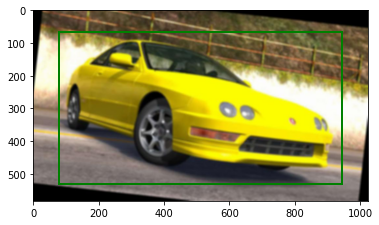

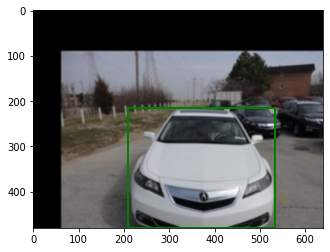

In [26]:
 ## Displaying images and bounding boxes 
display_aug_img_bb(30)
display_aug_img_bb(50) 

In [27]:
# Use this if the dataframe for the original data is saved before
org_df = pd.read_csv('/content/drive/MyDrive/Capstone/Prasad/MobileNet/14Jan_1/org_df.csv')  

In [29]:
''' Use this to create dataframe for original data
## creating a dataframe from original images

org_df = pd.DataFrame(columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax','class'])

train_folder=glob.glob(dataset_folder + 'train/*/*')
for j in range(len(train_folder)):
  index=file_names.index(train_folder[j].split('/')[-1])

  (x1,y1,x2,y2)=bboxes[index]
  org_filename=train_folder[j].split('/')[-1]
  org_classname=train_folder[j].split('/')[-2]
  org_file_path=os.path.join(dataset_folder + 'train/'+org_classname+'/'+org_filename)
  org_df = org_df.append({'filename' : org_file_path, 'xmin' : x1, 'ymin' :y1,'xmax' : x2,'ymax' :y2, 'class' : org_classname}  ,ignore_index = True) 

pd.set_option('display.max_colwidth', -1)
org_df = org_df.reset_index()
org_df = org_df.drop(['index'], axis=1)
#org_df.to_csv('/content/drive/MyDrive/Capstone/car_data/org_df.csv', index=False )

'''

" Use this to create dataframe for original data\n## creating a dataframe from original images\n\norg_df = pd.DataFrame(columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax','class'])\n\ntrain_folder=glob.glob(dataset_folder + 'train/*/*')\nfor j in range(len(train_folder)):\n  index=file_names.index(train_folder[j].split('/')[-1])\n\n  (x1,y1,x2,y2)=bboxes[index]\n  org_filename=train_folder[j].split('/')[-1]\n  org_classname=train_folder[j].split('/')[-2]\n  org_file_path=os.path.join(dataset_folder + 'train/'+org_classname+'/'+org_filename)\n  org_df = org_df.append({'filename' : org_file_path, 'xmin' : x1, 'ymin' :y1,'xmax' : x2,'ymax' :y2, 'class' : org_classname}  ,ignore_index = True) \n\npd.set_option('display.max_colwidth', -1)\norg_df = org_df.reset_index()\norg_df = org_df.drop(['index'], axis=1)\n#org_df.to_csv('/content/drive/MyDrive/Capstone/car_data/org_df.csv', index=False )\n\n"

In [30]:
org_df.head(1)

,filename,xmin,ymin,xmax,ymax,class
0,/content/drive/MyDrive/Capstone/car_data/train...,29,78,734,396,Acura Integra Type R 2001


In [31]:
##Now we have total two train dataframes 
#Orginal images =org_df
#Aug images =aug_bbs_xy

#Shape of orginal df
print(org_df.shape)
#Shape of aug img df 
print(aug_bbs_xy.shape)


(8144, 6)
(8144, 6)


In [32]:
## merging two datafames into one common dataframe where we can get all the details about both org images and arg images 
final_train_df=  pd.DataFrame(columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax','class'])
final_train_df = pd.concat([org_df, aug_bbs_xy], ignore_index=True)
final_train_df = final_train_df.reset_index()
final_train_df = final_train_df.drop(['index'], axis=1)
print(final_train_df.shape)
#final_train_df.to_csv('/content/drive/MyDrive/Capstone/car_data/final_train_df.csv', index=False )
final_train_df.head(1)

(16288, 6)


,filename,xmin,ymin,xmax,ymax,class
0,/content/drive/MyDrive/Capstone/car_data/train...,29.0,78.0,734.0,396.0,Acura Integra Type R 2001


In [33]:
## displaying images and bounding box
def display_images_with_bb(k):

  x1=final_train_df['xmin'][k]
  y1=final_train_df['ymin'][k]
  x2=final_train_df['xmax'][k]
  y2=final_train_df['ymax'][k]
  path1 =final_train_df['filename'][k]
  print(path1)
  print(type(path1))

  unscaled=cv2.imread(path1)[...,::-1]
  fig, ax=plt.subplots(1)
  ax.imshow(unscaled)
  rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
  ax.add_patch(rect)
  plt.show()

/content/drive/MyDrive/Capstone/car_data/train/Acura Integra Type R 2001/07800.jpg
<class 'str'>


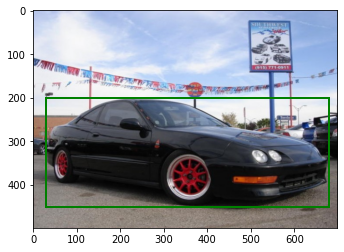

/content/drive/MyDrive/Capstone/car_data/train/AM General Hummer SUV 2000/07684.jpg
<class 'str'>


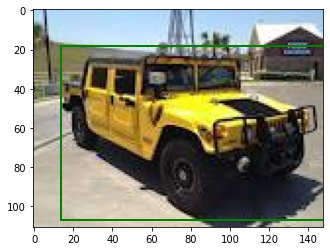

/content/drive/MyDrive/Capstone/car_data/train/Aston Martin V8 Vantage Convertible 2012/03379.jpg
<class 'str'>


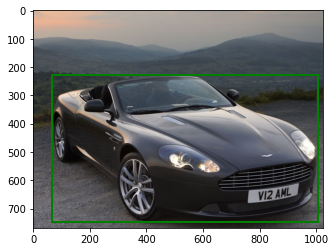

In [34]:
display_images_with_bb(20)
display_images_with_bb(200)
display_images_with_bb(305)

In [35]:
IMAGE_SIZE=224

In [36]:
''' # Remove quotes in the front to generate the train data arrays of only original images

##Data preparation for model building 

trainImagePaths=[]
trainBboxes =[]
trainLabels=[]
#trainData=[]
# below is the alternate approach
trainData= np.zeros((len(cars_annos_train), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)

train_folder=glob.glob(dataset_folder + 'train/*/*')
for j in range(len(train_folder)):
  index=file_names.index(train_folder[j].split('/')[-1])

  (x1,y1,x2,y2)=bboxes[index]
  filename=train_folder[j].split('/')[-1]
  classname=train_folder[j].split('/')[-2]
  file_path=os.path.join(dataset_folder + 'train/'+classname+'/'+filename)

  trainImagePaths.append(file_path) ## image paths
  trainLabels.append(classname) ## image labes
  
  # below 3 lines can be replaced by last two lines
  #ResizeImage=load_img(file_path, target_size=(224,224))
  #ResizeImage=img_to_array(ResizeImage)
  #trainData.append(ResizeImage) ## Resized images
  
  # Resizing the coordinates
  originalImage=cv2.imread(file_path)
  (h,w)=originalImage.shape[:2]
  startX=float(x1)/w
  startY=float(y1)/h
  endX=float(x2)/w
  endY=float(y2)/h
  trainBboxes.append((startX,startY,endX,endY))
  trainData[j] = cv2.resize(originalImage, dsize=(IMAGE_SIZE, IMAGE_SIZE),interpolation=cv2.INTER_AREA)
  #  trainData[j] = preprocess_input(np.array(trainData[j], dtype=np.float32))

trainData=np.array(trainData, dtype='float32')/255.0
trainLabels=np.array(trainLabels)
trainBboxes=np.array(trainBboxes, dtype='float32')
trainImagePaths=np.array(trainImagePaths)

np.save(dataset_folder+ 'trainData.npy', trainData) # save the file as "outfile_name.npy" 
np.save(dataset_folder+ 'trainLabels.npy', trainLabels)
np.save(dataset_folder+ 'trainBboxes.npy', trainBboxes)
np.save(dataset_folder+ 'trainImagePaths.npy', trainImagePaths)

'''

' # Remove quotes in the front to generate the train data arrays of only original images\n\n##Data preparation for model building \n\ntrainImagePaths=[]\ntrainBboxes =[]\ntrainLabels=[]\n#trainData=[]\n# below is the alternate approach\ntrainData= np.zeros((len(cars_annos_train), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)\n\ntrain_folder=glob.glob(dataset_folder + \'train/*/*\')\nfor j in range(len(train_folder)):\n  index=file_names.index(train_folder[j].split(\'/\')[-1])\n\n  (x1,y1,x2,y2)=bboxes[index]\n  filename=train_folder[j].split(\'/\')[-1]\n  classname=train_folder[j].split(\'/\')[-2]\n  file_path=os.path.join(dataset_folder + \'train/\'+classname+\'/\'+filename)\n\n  trainImagePaths.append(file_path) ## image paths\n  trainLabels.append(classname) ## image labes\n  \n  # below 3 lines can be replaced by last two lines\n  #ResizeImage=load_img(file_path, target_size=(224,224))\n  #ResizeImage=img_to_array(ResizeImage)\n  #trainData.append(ResizeImage) ## Resized images\n  \

In [37]:
'''
for j in range(len(trainImagePaths)):
  unscaled=cv2.imread(trainImagePaths[j])[...,::-1]
  (h,w)=unscaled.shape[:2]
  print(trainImagePaths[j])
  print ('Class Name ->', trainLabels[j]) 
  fig, ax=plt.subplots(1)
  ax.imshow(unscaled)
  x1=trainBboxes[j][0]*w
  y1=trainBboxes[j][1]*h
  x2=trainBboxes[j][2]*w
  y2=trainBboxes[j][3]*h
  rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.show()

  if j==3:
    break
 
'''   

"\nfor j in range(len(trainImagePaths)):\n  unscaled=cv2.imread(trainImagePaths[j])[...,::-1]\n  (h,w)=unscaled.shape[:2]\n  print(trainImagePaths[j])\n  print ('Class Name ->', trainLabels[j]) \n  fig, ax=plt.subplots(1)\n  ax.imshow(unscaled)\n  x1=trainBboxes[j][0]*w\n  y1=trainBboxes[j][1]*h\n  x2=trainBboxes[j][2]*w\n  y2=trainBboxes[j][3]*h\n  rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')\n  ax.add_patch(rect)\n  plt.show()\n\n  if j==3:\n    break\n \n"

In [38]:
''' # Remove quotes in the front to generate the train data arrays of combined augmented images
trainImagePaths=[]
trainBboxes =[]
trainLabels=[]

trainData= np.zeros((len(final_train_df), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)

for i in range(len(final_train_df)):
  row_obj=final_train_df.iloc[i]
  fname=row_obj[0]
  bbx1=row_obj[1]
  bbx2=row_obj[2]
  bbx3=row_obj[3]
  bbx4=row_obj[4]
  clable=row_obj[5]

  #appending values to list
  trainImagePaths.append(fname)
  trainLabels.append(clable)

  ## operations on images and bounding boxes 
  org_img=cv2.imread(fname)
  (h,w)=org_img.shape[:2]
  startX=float(bbx1)/w
  startY=float(bbx2)/h
  endX=float(bbx3)/w
  endY=float(bbx4)/h
  trainBboxes.append((startX,startY,endX,endY))

  trainData[i]=cv2.resize(org_img, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)


trainData=np.array(trainData, dtype='float32')/255.0
trainLabels=np.array(trainLabels)
trainBboxes=np.array(trainBboxes, dtype='float32')
trainImagePaths=np.array(trainImagePaths)

np.save(dataset_folder+ 'trainData.npy', trainData) # save the file as "outfile_name.npy" 
np.save(dataset_folder+ 'trainLabels.npy', trainLabels)
np.save(dataset_folder+ 'trainBboxes.npy', trainBboxes)
np.save(dataset_folder+ 'trainImagePaths.npy', trainImagePaths)

'''

' # Remove quotes in the front to generate the train data arrays of combined augmented images\ntrainImagePaths=[]\ntrainBboxes =[]\ntrainLabels=[]\n\ntrainData= np.zeros((len(final_train_df), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)\n\nfor i in range(len(final_train_df)):\n  row_obj=final_train_df.iloc[i]\n  fname=row_obj[0]\n  bbx1=row_obj[1]\n  bbx2=row_obj[2]\n  bbx3=row_obj[3]\n  bbx4=row_obj[4]\n  clable=row_obj[5]\n\n  #appending values to list\n  trainImagePaths.append(fname)\n  trainLabels.append(clable)\n\n  ## operations on images and bounding boxes \n  org_img=cv2.imread(fname)\n  (h,w)=org_img.shape[:2]\n  startX=float(bbx1)/w\n  startY=float(bbx2)/h\n  endX=float(bbx3)/w\n  endY=float(bbx4)/h\n  trainBboxes.append((startX,startY,endX,endY))\n\n  trainData[i]=cv2.resize(org_img, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)\n\n\ntrainData=np.array(trainData, dtype=\'float32\')/255.0\ntrainLabels=np.array(trainLabels)\ntrainBboxes=np.array(trainBboxes, dt

In [39]:
def display_scaled_img_bb(j):
  unscaled=cv2.imread(trainImagePaths[j])[...,::-1]
  (h,w)=unscaled.shape[:2]
  print(trainImagePaths[j])
  print ('Class Name ->', trainLabels[j]) 
  fig, ax=plt.subplots(1)
  ax.imshow(unscaled)
  x1=trainBboxes[j][0]*w
  y1=trainBboxes[j][1]*h
  x2=trainBboxes[j][2]*w
  y2=trainBboxes[j][3]*h
  rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.show()

/content/drive/MyDrive/Capstone/car_data/train/AM General Hummer SUV 2000/07684.jpg
Class Name -> AM General Hummer SUV 2000


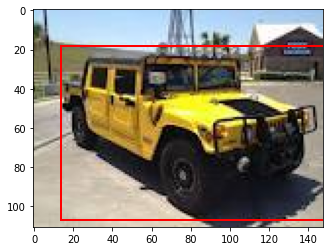

/content/drive/MyDrive/Capstone/car_data/train/Acura TL Type-S 2008/00392.jpg
Class Name -> Acura TL Type-S 2008


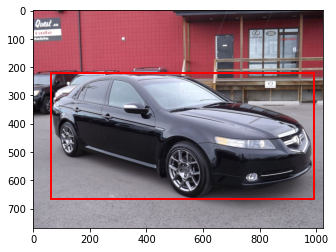

In [40]:
display_scaled_img_bb(200)
display_scaled_img_bb(120)

In [41]:
#Checks 
print(trainImagePaths[:2])
print(trainBboxes[:2])
print(trainLabels[:2])
#print(trainData[:2])
print('***********************')
print(trainData.shape)
print(trainBboxes.shape)
print(trainBboxes[1])
print(trainLabels[1])

['/content/drive/MyDrive/Capstone/car_data/train/Acura Integra Type R 2001/00255.jpg'
 '/content/drive/MyDrive/Capstone/car_data/train/Acura Integra Type R 2001/01010.jpg']
[[0.03666245 0.18483412 0.9279393  0.93838865]
 [0.00626959 0.0046875  0.9738767  0.9984375 ]]
['Acura Integra Type R 2001' 'Acura Integra Type R 2001']
***********************
(16288, 224, 224, 3)
(16288, 4)
[0.00626959 0.0046875  0.9738767  0.9984375 ]
Acura Integra Type R 2001


In [42]:
print(trainImagePaths[:2])
print(trainBboxes[:2])
print(trainLabels[:2])
#print(trainData[:2])

['/content/drive/MyDrive/Capstone/car_data/train/Acura Integra Type R 2001/00255.jpg'
 '/content/drive/MyDrive/Capstone/car_data/train/Acura Integra Type R 2001/01010.jpg']
[[0.03666245 0.18483412 0.9279393  0.93838865]
 [0.00626959 0.0046875  0.9738767  0.9984375 ]]
['Acura Integra Type R 2001' 'Acura Integra Type R 2001']


In [43]:
print(trainData.shape)
print(trainBboxes.shape)
print(trainBboxes[1])
print(trainLabels[1])

(16288, 224, 224, 3)
(16288, 4)
[0.00626959 0.0046875  0.9738767  0.9984375 ]
Acura Integra Type R 2001


In [44]:
## performing one hot encoding on the labels 

lb=LabelBinarizer()
trainLabels_lb=lb.fit_transform(trainLabels)

In [45]:
print(trainLabels_lb.shape)
print(trainLabels_lb[10])

(16288, 196)
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [46]:
#For Test data set 
test_file_names=[]
test_class_ids=[]
test_bboxes=[]
test_labels=[]

for i in range(len(cars_annos_test)):
  annotations=cars_annos_test.iloc[i]
  

  test_bboxs_x1=annotations[1]
  test_bboxs_x2=annotations[2]
  test_bboxs_x3=annotations[3]
  test_bboxs_x4=annotations[4]
  test_bboxes.append((test_bboxs_x1,test_bboxs_x2,test_bboxs_x3,test_bboxs_x4))

  test_class_id=annotations[5]
  test_labels.append('%04d' %(test_class_id,))

  test_file_names.append(annotations[0])

  test_class_ids.append(annotations[5])

In [47]:
## Comparing between file names, coordinates and their labels 
print(test_file_names[:5])
print(test_bboxes[:5])
print(test_class_ids[:5])
print(test_labels[:5])

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']
[(30, 52, 246, 147), (100, 19, 576, 203), (51, 105, 968, 659), (67, 84, 581, 407), (140, 151, 593, 339)]
[181, 103, 145, 187, 185]
['0181', '0103', '0145', '0187', '0185']


In [48]:
cars_annos_test.shape

(8041, 6)

In [49]:
# Use these presaved arrays to speed up the process#
testData = np.load('/content/drive/MyDrive/Capstone/Prasad/MobileNet/09Jan_3/testData.npy') # loads your saved array into variable a.
testLabels = np.load('/content/drive/MyDrive/Capstone/Prasad/MobileNet/09Jan_3/testLabels.npy')
testBboxes = np.load('/content/drive/MyDrive/Capstone/Prasad/MobileNet/09Jan_3/testBboxes.npy')
testImagePaths = np.load('/content/drive/MyDrive/Capstone/Prasad/MobileNet/09Jan_3/testImagePaths.npy')

In [50]:
'''# remove quotes to generate the data arrays
##Data preparation for model building 

testImagePaths=[]
testBboxes =[]
testLabels=[]
#testData=[]
# below is the alternate approach
testData= np.zeros((len(cars_annos_test), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)

test_folder=glob.glob(dataset_folder + 'test/*/*')
for j in range(len(test_folder)):
  index=test_file_names.index(test_folder[j].split('/')[-1])

  (x1,y1,x2,y2)=test_bboxes[index]
  test_filename=test_folder[j].split('/')[-1]
  classname=test_folder[j].split('/')[-2]
  test_file_path=os.path.join(dataset_folder + 'test/'+classname+'/'+test_filename)

  testImagePaths.append(test_file_path) ## image paths
  testLabels.append(classname) ## image labes
  
  # below 3 lines can be replaced by last two lines
  #ResizeImage=load_img(test_file_path, target_size=(224,224))
  #ResizeImage=img_to_array(ResizeImage)
  #testData.append(ResizeImage) ## Resized images
  
  # Resizing the coordinates
  originalImage=cv2.imread(test_file_path)
  (h,w)=originalImage.shape[:2]
  startX=float(x1)/w
  startY=float(y1)/h
  endX=float(x2)/w
  endY=float(y2)/h
  testBboxes.append((startX,startY,endX,endY))
  testData[j] = cv2.resize(originalImage, dsize=(IMAGE_SIZE, IMAGE_SIZE),interpolation=cv2.INTER_AREA)
  #  testData[j] = preprocess_input(np.array(testData[j], dtype=np.float32))

testData=np.array(testData, dtype='float32')/255.0
testLabels=np.array(testLabels)
testBboxes=np.array(testBboxes, dtype='float32')
testImagePaths=np.array(testImagePaths)

np.save(dataset_folder+ 'testData.npy', testData) # save the file as "outfile_name.npy" 
np.save(dataset_folder+ 'testLabels.npy', testLabels)
np.save(dataset_folder+ 'testBboxes.npy', testBboxes)
np.save(dataset_folder+ 'testImagePaths.npy', testImagePaths)

'''


'# remove quotes to generate the data arrays\n##Data preparation for model building \n\ntestImagePaths=[]\ntestBboxes =[]\ntestLabels=[]\n#testData=[]\n# below is the alternate approach\ntestData= np.zeros((len(cars_annos_test), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)\n\ntest_folder=glob.glob(dataset_folder + \'test/*/*\')\nfor j in range(len(test_folder)):\n  index=test_file_names.index(test_folder[j].split(\'/\')[-1])\n\n  (x1,y1,x2,y2)=test_bboxes[index]\n  test_filename=test_folder[j].split(\'/\')[-1]\n  classname=test_folder[j].split(\'/\')[-2]\n  test_file_path=os.path.join(dataset_folder + \'test/\'+classname+\'/\'+test_filename)\n\n  testImagePaths.append(test_file_path) ## image paths\n  testLabels.append(classname) ## image labes\n  \n  # below 3 lines can be replaced by last two lines\n  #ResizeImage=load_img(test_file_path, target_size=(224,224))\n  #ResizeImage=img_to_array(ResizeImage)\n  #testData.append(ResizeImage) ## Resized images\n  \n  # Resizing the coordinat

In [51]:
print(testImagePaths[:2])
print(testBboxes[:2])
print(testLabels[:2])
#print(testData[:2])

['/content/drive/MyDrive/Capstone/car_data/test/AM General Hummer SUV 2000/01461.jpg'
 '/content/drive/MyDrive/Capstone/car_data/test/AM General Hummer SUV 2000/00076.jpg']
[[0.1958042  0.15053764 0.8251748  0.86021507]
 [0.11458334 0.203125   0.875      0.9375    ]]
['AM General Hummer SUV 2000' 'AM General Hummer SUV 2000']


In [52]:
print(testData.shape)
print(testBboxes.shape)
print(testBboxes[1])
print(testLabels[1])

(8041, 224, 224, 3)
(8041, 4)
[0.11458334 0.203125   0.875      0.9375    ]
AM General Hummer SUV 2000


In [53]:
## performing one hot encoding on the labels 

lb=LabelBinarizer()
testLabels_lb=lb.fit_transform(testLabels)

In [54]:
print(testLabels_lb.shape)
print(testLabels_lb[10])

(8041, 196)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [55]:
#lb.classes_

In [56]:
'''# use this to split train and validation
#Spliting data for train and validation 
split=train_test_split(trainData, trainLabels_lb, trainBboxes, trainImagePaths, test_size=0.10, random_state=42)
#unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
'''

'# use this to split train and validation\n#Spliting data for train and validation \nsplit=train_test_split(trainData, trainLabels_lb, trainBboxes, trainImagePaths, test_size=0.10, random_state=42)\n#unpack the data split\n(trainImages, testImages) = split[:2]\n(trainLabels, testLabels) = split[2:4]\n(trainBBoxes, testBBoxes) = split[4:6]\n(trainPaths, testPaths) = split[6:]\n'

In [57]:
mobnet = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),include_top=False, alpha=1)
#vgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

print('No. of Layers:', len(mobnet.layers))

# to Print the names of the layers
'''
for i,layer in enumerate(mobnet.layers):
    print(i,layer.name)
'''

17227776/17225924 [==============================] - 0s 0us/step
No. of Layers: 86


'\nfor i,layer in enumerate(mobnet.layers):\n    print(i,layer.name)\n'

In [58]:
# freeze all layers so they will *not* be updated during the training process
#mobnet.trainable = False
# to train few discrete layers
'''
mobnet.trainable = True

set_trainable = False
for layer in mobnet.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)
'''

'\nmobnet.trainable = True\n\nset_trainable = False\nfor layer in mobnet.layers:\n    if layer.name in [\'block5_conv1\', \'block4_conv1\']:\n        set_trainable = True\n    if set_trainable:\n        layer.trainable = True\n    else:\n        layer.trainable = False\n        \nprint("Trainable layers:", vgg_model.trainable_weights)\n'

In [59]:
for layer in mobnet.layers[:40]:
    layer.trainable=False
for layer in mobnet.layers[40:]:
    layer.trainable=True
#print("Trainable layers:", mobnet.trainable_weights)

In [60]:
# Flatten the max pooling output
#output = vgg.layers[-1].output
output=mobnet.output # 0r output = mobnet.layers[-1].output
flatten=Flatten()(output)

In [61]:
# construct a fully-connected layer header to output the predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",name="class_label")(softmaxHead)

In [62]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels_lb,
	"bounding_box": trainBboxes
}

# construct a second dictionary, this one for our target testing outputs
testTargets = {
	"class_label": testLabels_lb,
	"bounding_box": testBboxes
}

In [63]:
# define a dictionary to set the loss methods -- categorical cross-entropy for the class label head and mean absolute error for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the  class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# weights can be changed

In [64]:
# put together our model which accept an input image and then output bounding box coordinates and a class label
model = Model( inputs=mobnet.input, outputs=(bboxHead, softmaxHead))

In [65]:
# initialize the optimizer, compile the model, and show the model summary
#INIT_LR = 1e-4

opt = optimizers.RMSprop(lr=1e-5) #Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [66]:
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
#df[39:]# to check the status False / True

In [67]:
# Use earlystopping
#callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)# for bboxes

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [68]:
print("[INFO] training model...")
H = model.fit(
	trainData, trainTargets,
	validation_data=(testData, testTargets),
	batch_size=32,
	epochs=100,
	verbose=1, 
  callbacks=callbacks_list)

[INFO] training model...
Epoch 1/100
509/509 [==============================] - 41s 66ms/step - loss: 6.0259 - bounding_box_loss: 0.0125 - class_label_loss: 6.0134 - bounding_box_accuracy: 0.6144 - class_label_accuracy: 0.0043 - val_loss: 5.2822 - val_bounding_box_loss: 0.0030 - val_class_label_loss: 5.2792 - val_bounding_box_accuracy: 0.7839 - val_class_label_accuracy: 0.0075
Epoch 2/100
509/509 [==============================] - 32s 64ms/step - loss: 5.2821 - bounding_box_loss: 0.0029 - class_label_loss: 5.2792 - bounding_box_accuracy: 0.7794 - class_label_accuracy: 0.0070 - val_loss: 5.2755 - val_bounding_box_loss: 0.0025 - val_class_label_loss: 5.2730 - val_bounding_box_accuracy: 0.8110 - val_class_label_accuracy: 0.0071
Epoch 3/100
509/509 [==============================] - 33s 64ms/step - loss: 5.2581 - bounding_box_loss: 0.0021 - class_label_loss: 5.2561 - bounding_box_accuracy: 0.8150 - class_label_accuracy: 0.0073 - val_loss: 5.2710 - val_bounding_box_loss: 0.0022 - val_class_

In [69]:
# Serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format='h5')

[INFO] saving object detector model...


In [70]:
#serialize the label binarizer to disk
f=open(LB_PATH, 'wb')
f.write(pickle.dumps(lb))
f.close()

## References

Image and BBox Augmentation:
https://medium.com/@a.karazhay/guide-augment-images-and-multiple-bounding-boxes-for-deep-learning-in-4-steps-with-the-notebook-9b263e414dac